In this notebook we show the unsupervised graph coloring method using gated graph neural network applied for frequency allocation in wireless multicellular system in the paper [D. Abode, R. Adeogun, L. Salaün, R. Abreu, T. Jacobsen and G. Berardinelli, "Unsupervised Graph-based Learning Method for Sub-band Allocation in 6G Subnetworks," 2024 IEEE 100th Vehicular Technology Conference (VTC2024-Fall), Washington, DC, USA, 2024, pp. 1-6, doi: 10.1109/VTC2024-Fall63153.2024.10757647](https://arxiv.org/abs/2401.00950)

Please note the `requirements.txt` file, which defines the environment required to run this code

If you find the code useful, kindly cite the corresponding paper -

@INPROCEEDINGS{10757647,\
  author={Abode, Daniel and Adeogun, Ramoni and Salaün, Lou and Abreu, Renato and Jacobsen, Thomas and Berardinelli, Gilberto}, \
  booktitle={2024 IEEE 100th Vehicular Technology Conference (VTC2024-Fall)}, \
  title={Unsupervised Graph-based Learning Method for Sub-band Allocation in 6G Subnetworks}, \
  year={2024}, \
  pages={1-6}, \
  doi={10.1109/VTC2024-Fall63153.2024.10757647}\
  }

In [24]:
import numpy as np                         # import numpy
import matplotlib.pyplot as plt            # import matplotlib.pyplot for figure plotting
import torch
import torch.nn as nn
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
import networkx as nx
from torch_geometric.utils.convert import to_networkx, from_networkx
from torch_geometric.transforms import ToUndirected

from utils import *

In [31]:
import platform
print("Python version:", platform.python_version())  #3.11.5
print('torch version ', torch.__version__)  #2.1.0
print('torch_geometric version ', torch_geometric.__version__) #2.5.2
print('networkx version ', nx.__version__) #3.1
print('numpy version ', np.__version__) #1.26.0

Python version: 3.11.5
torch version  2.1.0
torch_geometric version  2.5.2
networkx version  3.1
numpy version  1.26.0


In [19]:
# Generate random graphs with same K-colorable 
num_nodes = 20
max_degree = 4  # Ensures 5-colorable graph
num_of_training_graphs = 1000 #Number of training graph can be increased for better performance
graph_list = generate_colorable_graph_list(num_of_training_graphs,num_nodes, max_degree)
validation_graph_list = generate_colorable_graph_list(200,num_nodes, max_degree)
graph = to_networkx(graph_list[0])


## Training

tensor([3, 1, 1, 3, 2, 4, 4, 1, 2, 4, 2, 2, 4, 2, 4, 2, 4, 3, 2, 1],
       device='cuda:0')
Epoch 001, Train Loss: 14.1300, Val Loss: 14.1230, Val hard error: 11578.0
tensor([3, 1, 1, 4, 2, 4, 4, 1, 2, 4, 2, 2, 4, 2, 4, 2, 4, 3, 2, 1],
       device='cuda:0')
Epoch 002, Train Loss: 14.1258, Val Loss: 14.1229, Val hard error: 10786.0
tensor([3, 1, 0, 4, 2, 4, 4, 0, 2, 4, 2, 2, 4, 2, 4, 2, 4, 3, 2, 0],
       device='cuda:0')
Epoch 003, Train Loss: 14.1229, Val Loss: 14.1229, Val hard error: 10721.0
tensor([3, 0, 0, 4, 2, 4, 4, 0, 2, 4, 2, 2, 4, 2, 4, 2, 4, 3, 2, 0],
       device='cuda:0')
Epoch 004, Train Loss: 14.1195, Val Loss: 14.1228, Val hard error: 10771.0
tensor([3, 0, 0, 4, 2, 4, 4, 0, 2, 4, 2, 2, 4, 2, 4, 2, 4, 3, 2, 0],
       device='cuda:0')
Epoch 005, Train Loss: 14.1221, Val Loss: 14.1228, Val hard error: 10326.0
tensor([3, 0, 0, 4, 2, 4, 4, 0, 2, 4, 2, 2, 4, 2, 4, 2, 4, 3, 2, 0],
       device='cuda:0')
Epoch 006, Train Loss: 14.1209, Val Loss: 14.1227, Val hard error: 

Text(0.5, 0, 'epochs')

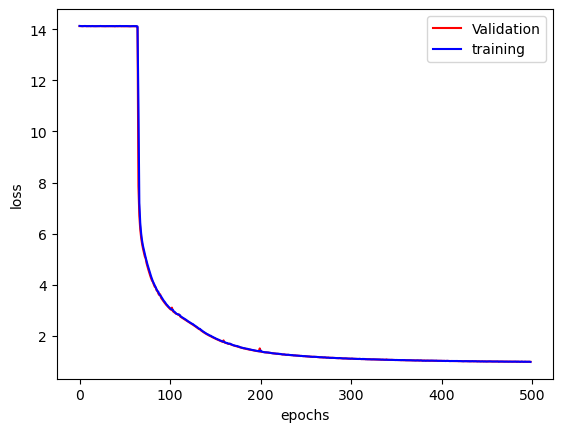

In [ ]:
num_of_layers = 16 #Number of GGNN layers, can be reduced to reduce complexity
output_embedding_dim = 64  #Size of embedding, can be increased to improve performance, or reduced to reduce complexity
K = 5 #number of colors
torch_device = 'cuda'
model_type = 'GGNN'
save_name = 'first_run'
num_of_epochs = 500

train_loader = DataLoader(graph_list, batch_size=64, shuffle=True)
validation_loader = DataLoader(graph_list, batch_size=64, shuffle=False)

model = PICAN(output_embedding_dim, num_of_layers, K, model_type).to(torch_device)
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.9)

plt.figure()
loss_, losst_, hard_ = trainmodel('model'+save_name, model, num_of_epochs, scheduler, train_loader,validation_loader, optimizer,torch_device,num_nodes,K) #xyzg not BN()StraightThroughEstimator
print('min loss = ', np.min(np.array(loss_)))
print('At epoch ', np.argmin(np.array(loss_)))
print('max loss = ', np.max(np.array(loss_)))
print('Minimum wrong decision = ', np.min(np.array(hard_)))
print('At epoch = ', np.argmin(np.array(hard_)))
print(np.max(np.array(loss_)) - np.min(np.array(loss_)))
plt.plot(np.array(loss_), 'r', np.array(losst_), 'b')
plt.legend(('Validation','training'))
plt.ylabel('loss')
plt.xlabel('epochs')


## Testing

{0: 1, 1: 1, 2: 1, 3: 1, 4: 3, 5: 0, 6: 3, 7: 1, 8: 1, 9: 3, 10: 1, 11: 0, 12: 2, 13: 0, 14: 0, 15: 3, 16: 3, 17: 3, 18: 3, 19: 0}


C:\Users\VQ72TN\AppData\Local\Temp\ipykernel_32028\975163386.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = plt.cm.get_cmap("tab10", max_color)


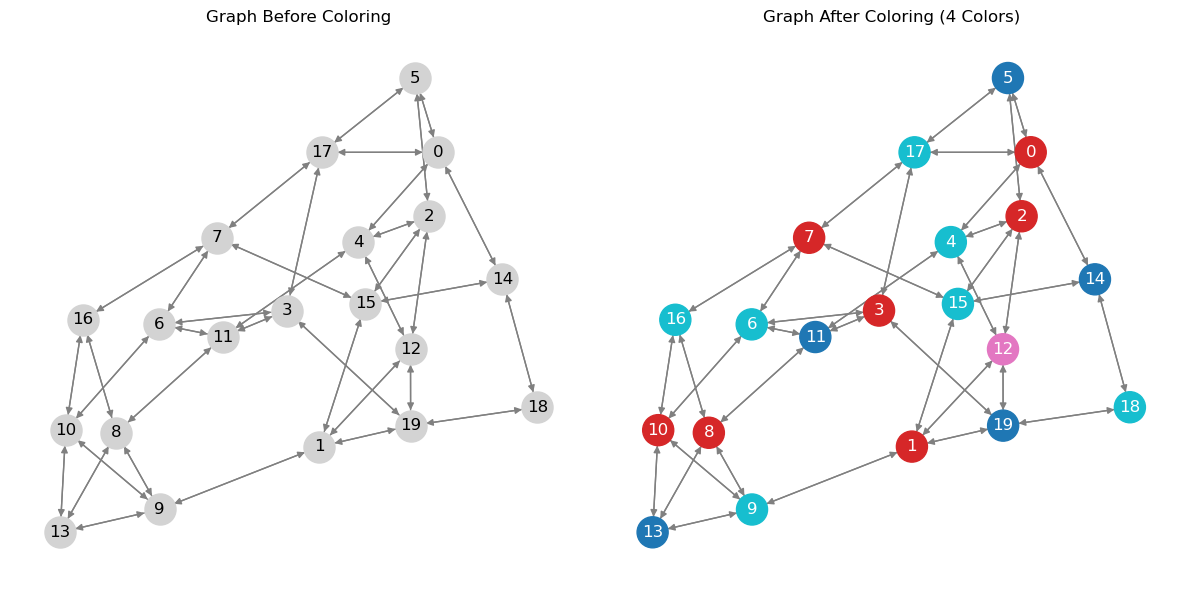

In [21]:
#Testing
model = torch.load('models/hardlossmodelfirst_run')
graph_list = generate_colorable_graph_list(1,num_nodes, max_degree)
graph = to_networkx(graph_list[0])

test_loader = DataLoader(graph_list, batch_size=1, shuffle=False)

for data in test_loader:
    data = data.to(torch_device)
    with torch.no_grad():
        model = model.to('cpu')
        out_hat = model(data.to('cpu'))
        num_c = torch.argmax(out_hat.to('cpu'), dim=-1).unique().shape[0]
        outg = F.one_hot(torch.argmax(out_hat.to('cpu'),dim=-1), num_classes=K)

colors={}
for i in range(num_nodes):
    colors[i] = np.argmax(outg[i]).item()
print(colors)
# # Compute node coloring
# colors = nx.coloring.greedy_color(graph, strategy="largest_first")
# max_color = max(colors.values()) + 1  # Number of colors used
# print(colors)
# Map color indices to a palette of distinct colors
color_palette = plt.cm.get_cmap("tab10", max_color)
node_colors = [color_palette(colors[node]) for node in graph.nodes()]

# Layout for both plots
pos = nx.spring_layout(graph, seed=42)

# Plot the graph before coloring
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
nx.draw(
    graph, pos, with_labels=True, node_color='lightgray',
    node_size=500, edge_color='gray', font_color='black'
)
plt.title("Graph Before Coloring")

# Plot the graph after coloring
plt.subplot(1, 2, 2)
nx.draw(
    graph, pos, with_labels=True, node_color=node_colors,
    node_size=500, edge_color='gray', font_color='white'
)
plt.title(f"Graph After Coloring ({max_color} Colors)")

# Show the plots
plt.tight_layout()
plt.show()